In [1]:
%load_ext autoreload
%autoreload 2

# Experimental 001

## Setup

In [2]:
from multiprocessing import process
from athena_analyze.data.processor import DataProcessor
from utils.logging import setup_logging
from utils.config import load_config_section, load_config

_log = setup_logging()
data_cfg = load_config_section("../config/config.yml", "data")
processor = DataProcessor(data_fol=data_cfg["raw"])
dfs = []
dfs.append(processor.load_data("ETTh1.csv"))
dfs.append(processor.load_data("ETTh2.csv"))

2026-02-04 13:42:08,261 - athena-assignment - DEBUG - DataProcessor initialized with data folder: ../data/raw


# Preprocess

MSTLを用いて周期性の分解を行う。

In [3]:
pp_general_cfg = load_config_section("../config/config.yml", "preprocess")
pp_exp_cfg = load_config_section("../config/exp_001.yml", "preprocess")

train_dfs = []
test_dfs = []

for i, df in enumerate(dfs):
    _log.info(f"Processing dataset {i}")
    pp_cfg = dict(**pp_general_cfg, **pp_exp_cfg[f"h{i+1}"])
    train_df, test_df = processor.preprocess_data(df, **pp_cfg)
    train_dfs.append(train_df)
    test_dfs.append(test_df)

2026-02-04 13:42:08,375 - athena-assignment - INFO - Processing dataset 0
2026-02-04 13:42:08,376 - athena-assignment - DEBUG - Starting data preprocessing
2026-02-04 13:42:08,378 - athena-assignment - DEBUG - Dropped NA values, remaining rows: 17420
2026-02-04 13:42:08,386 - athena-assignment - DEBUG - Dropped duplicate rows, remaining rows: 17420
2026-02-04 13:42:08,386 - athena-assignment - INFO - Data Cleaning completed, starting Data Splitting
2026-02-04 13:42:08,404 - athena-assignment - DEBUG - Data split at {'train_start': '2016-07-01 00:00:00', 'train_end': '2018-02-01 13:59:59', 'test_start': '2018-02-01 14:00:00', 'test_end': '2018-06-26 19:00:00'}: 13934 training rows, 3486 testing rows
2026-02-04 13:42:08,405 - athena-assignment - INFO - Data Splitting completed
2026-02-04 13:42:08,405 - athena-assignment - DEBUG - Adding features: ['date_features', 'season', 'lag_features']
2026-02-04 13:42:08,424 - athena-assignment - DEBUG - Added 'year', 'month', 'day', 'weekday', 'yea

In [4]:
train_dfs[0].columns

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT', 'year',
       'month', 'day', 'weekday', 'yearmonth', 'season', 'stl_OT_trend',
       'stl_OT_seasonal_24', 'stl_OT_seasonal_72', 'stl_OT_resid',
       'stl_HUFL_trend', 'stl_HUFL_seasonal_12', 'stl_HUFL_seasonal_24',
       'stl_HUFL_resid', 'stl_HULL_trend', 'stl_HULL_seasonal_12',
       'stl_HULL_seasonal_24', 'stl_HULL_resid', 'stl_LUFL_trend',
       'stl_LUFL_seasonal_12', 'stl_LUFL_seasonal_24', 'stl_LUFL_resid',
       'stl_LULL_trend', 'stl_LULL_seasonal_12', 'stl_LULL_seasonal_24',
       'stl_LULL_resid', 'stl_MUFL_trend', 'stl_MUFL_seasonal_12',
       'stl_MUFL_seasonal_24', 'stl_MUFL_resid', 'stl_MULL_trend',
       'stl_MULL_seasonal_12', 'stl_MULL_seasonal_24', 'stl_MULL_resid',
       'OT_lag_1', 'OT_lag_3', 'OT_lag_6', 'HUFL_lag_1', 'HUFL_lag_3',
       'HUFL_lag_6', 'HULL_lag_1', 'HULL_lag_3', 'HULL_lag_6', 'LUFL_lag_1',
       'LUFL_lag_3', 'LUFL_lag_6', 'LULL_lag_1', 'LULL_lag_3', 'LULL_lag_6'

In [5]:
from logging import config
from utils.data_io import save_dataframe_to_parquet
data_cfg = load_config_section("../config/config.yml", "data")

for df, name in zip(train_dfs + test_dfs, ["train_h1", "train_h2", "test_h1", "test_h2"]):
    save_dataframe_to_parquet(df, f"exp_001/{name}.parquet", config=data_cfg)

2026-02-04 13:50:27,038 - athena-assignment - INFO - DataFrame saved to ../data/experiment/exp_001/train_h1.parquet
2026-02-04 13:50:27,126 - athena-assignment - INFO - DataFrame saved to ../data/experiment/exp_001/train_h2.parquet
2026-02-04 13:50:27,162 - athena-assignment - INFO - DataFrame saved to ../data/experiment/exp_001/test_h1.parquet
2026-02-04 13:50:27,187 - athena-assignment - INFO - DataFrame saved to ../data/experiment/exp_001/test_h2.parquet


2026-02-04 13:50:27,770 - athena-assignment - DEBUG - Plotting time series for columns: ['OT', 'stl_OT_seasonal_24', 'stl_OT_seasonal_72', 'stl_OT_resid', 'stl_OT_trend'] with date column: date


/var/folders/mr/9ycqbh915_5f4hxrq1w5yh6m0000gq/T/ipykernel_55636/2429100059.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


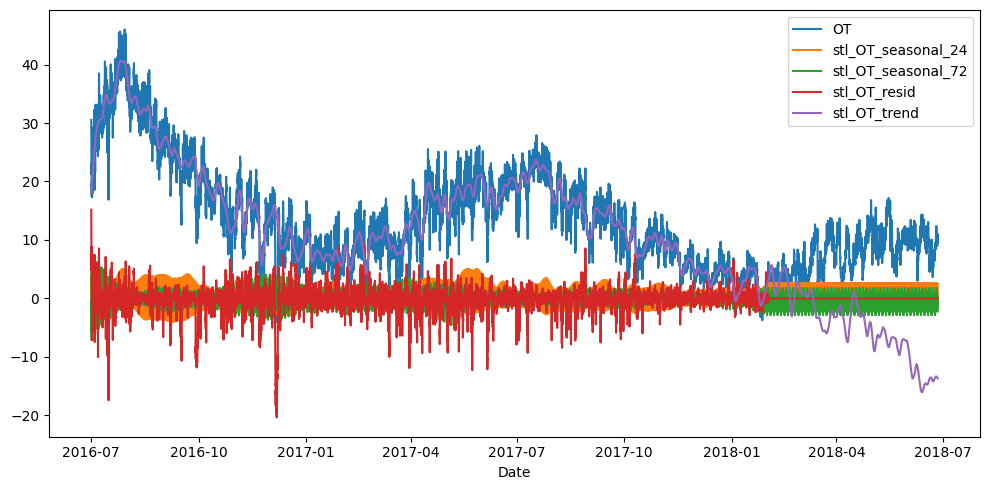

In [6]:
from athena_analyze.eda.visualize import plot_time_series
import pandas as pd

plot_df = pd.concat(
    [
        train_dfs[0],
        test_dfs[0],
    ]
)
fig = plot_time_series(df=plot_df, date_col="date",
                       value_cols=["OT", "stl_OT_seasonal_24",
                                   "stl_OT_seasonal_72", "stl_OT_resid", "stl_OT_trend"])
fig.show()

In [7]:
train_dfs[0].columns

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT', 'year',
       'month', 'day', 'weekday', 'yearmonth', 'season', 'stl_OT_trend',
       'stl_OT_seasonal_24', 'stl_OT_seasonal_72', 'stl_OT_resid',
       'stl_HUFL_trend', 'stl_HUFL_seasonal_12', 'stl_HUFL_seasonal_24',
       'stl_HUFL_resid', 'stl_HULL_trend', 'stl_HULL_seasonal_12',
       'stl_HULL_seasonal_24', 'stl_HULL_resid', 'stl_LUFL_trend',
       'stl_LUFL_seasonal_12', 'stl_LUFL_seasonal_24', 'stl_LUFL_resid',
       'stl_LULL_trend', 'stl_LULL_seasonal_12', 'stl_LULL_seasonal_24',
       'stl_LULL_resid', 'stl_MUFL_trend', 'stl_MUFL_seasonal_12',
       'stl_MUFL_seasonal_24', 'stl_MUFL_resid', 'stl_MULL_trend',
       'stl_MULL_seasonal_12', 'stl_MULL_seasonal_24', 'stl_MULL_resid',
       'OT_lag_1', 'OT_lag_3', 'OT_lag_6', 'HUFL_lag_1', 'HUFL_lag_3',
       'HUFL_lag_6', 'HULL_lag_1', 'HULL_lag_3', 'HULL_lag_6', 'LUFL_lag_1',
       'LUFL_lag_3', 'LUFL_lag_6', 'LULL_lag_1', 'LULL_lag_3', 'LULL_lag_6'

In [8]:
test_dfs[0].columns

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT', 'year',
       'month', 'day', 'weekday', 'yearmonth', 'season', 'stl_OT_seasonal_24',
       'stl_OT_seasonal_72', 'stl_OT_trend', 'stl_OT_resid',
       'stl_HUFL_seasonal_12', 'stl_HUFL_seasonal_24', 'stl_HUFL_trend',
       'stl_HUFL_resid', 'stl_HULL_seasonal_12', 'stl_HULL_seasonal_24',
       'stl_HULL_trend', 'stl_HULL_resid', 'stl_LUFL_seasonal_12',
       'stl_LUFL_seasonal_24', 'stl_LUFL_trend', 'stl_LUFL_resid',
       'stl_LULL_seasonal_12', 'stl_LULL_seasonal_24', 'stl_LULL_trend',
       'stl_LULL_resid', 'stl_MUFL_seasonal_12', 'stl_MUFL_seasonal_24',
       'stl_MUFL_trend', 'stl_MUFL_resid', 'stl_MULL_seasonal_12',
       'stl_MULL_seasonal_24', 'stl_MULL_trend', 'stl_MULL_resid', 'OT_lag_1',
       'OT_lag_3', 'OT_lag_6', 'HUFL_lag_1', 'HUFL_lag_3', 'HUFL_lag_6',
       'HULL_lag_1', 'HULL_lag_3', 'HULL_lag_6', 'LUFL_lag_1', 'LUFL_lag_3',
       'LUFL_lag_6', 'LULL_lag_1', 'LULL_lag_3', 'LULL_lag_6'